In [57]:
import sys
#in case of python2
from __future__ import division
import numpy as np

#setup the notebook
from IPython.display import display, Image
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

mpl.rcParams['axes.facecolor'] = 'FFFFFF'
mpl.rcParams['figure.facecolor'] = 'FFFFFF'
mpl.rcParams['figure.dpi'] = 130
mpl.rcParams['savefig.dpi'] = 92
mpl.rcParams['figure.figsize'] = [7.0, 3.0]

import sympy
print("Sympy version: ", sympy.__version__)
sympy.init_printing(use_latex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib
Sympy version:  1.0


/home/mcculler/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['eig']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [58]:
#for later thermal noise calculations
k_boltzman = 1.38064852e-23 #J/K
temp_K = 300

subsman = {}

bin_damp = sympy.var('B', real = True)

Mtm_kg = sympy.var('M_TM', real = True)
#make the pum the same as testmass, but semantic naming for clarity
Mpum_kg = Mtm_kg

#frequency of evaluation
F = sympy.var('F', real = True)

#variables for fiber mode
F_vio_Hz = sympy.var('F_vio', real = True)
M_fiber_kg = sympy.var('M_fiber', real = True)
k_fiber_N_m_val = (sympy.pi * 2 * F_vio)**2 * M_fiber
k_fiber_N_m = sympy.var('k_fiber', real = True)
subsman[k_fiber_N_m] = k_fiber_N_m_val

detune_F_D_Hz = sympy.var('F_Delta', real = True)
loss_fiber = 1e-9

#variables for damper mode
loss_D = sympy.var('theta_D', real = True)
M_D_kg = sympy.var('M_D', real = True)
k_D_N_m_val = (sympy.pi * 2 * (F_vio_Hz + detune_F_D_Hz))**2 * (M_D_kg * Mpum_kg) / (M_D_kg + Mpum_kg) / (1 + 2 * loss_D**2)**.5
k_D_N_m = sympy.var('k_D_N_m', real = True)
subsman[k_D_N_m] = k_D_N_m_val

#variables for pendulum mode
F_pend_Hz = sympy.var('F_pend', real = True)
#here we use the reduced mass between TM and PUM
k_pend_N_m = (sympy.pi * 2 * F_pend_Hz)**2 * Mtm_kg/2
k_pend_TMadj_N_m = k_pend_N_m - k_fiber_N_m

#for the PUM resonance, lower the frequency by 2x
k_pendPUM_N_m_val = (sympy.pi * 2 * F_pend_Hz/2)**2 * Mtm_kg
k_pendPUM_N_m = sympy.var('k_pendPUM')
subsman[k_pendPUM_N_m] = k_pendPUM_N_m_val

loss_pend = 1e-9

def logspaced(lower, upper, n_points):
    'helper to generate samplings for plots'
    log_lower = np.log(lower)
    log_upper = np.log(upper)
    return np.exp(np.linspace(log_lower, log_upper, n_points))

In [59]:
M_fiber_kg_true =  (205e-4**2 * np.pi * 1e2 * 2.2e-3) / 2 #divide by two for the harmonic mode
M_fiber_kg_true

In [60]:
k_D_N_m

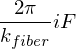

In [61]:
Zspring(k_fiber_N_m)

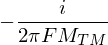

In [62]:
Zmass(Mtm_kg)

In [63]:
xp_vec = sympy.Matrix([sympy.var('x_1, p_1, x_2, p_2, x_3, p_3, x_4, p_4')]).T
display(xp_vec.T)

t = sympy.var('t')
xp_vecdt = sympy.Matrix([sympy.Derivative(v, t) for v in xp_vec])
display(xp_vecdt.T)

xp_vecdt = sympy.Matrix([sympy.Symbol('\dot{{{0}}}'.format(v)) for v in 'x_1, p_1, x_2, p_2, x_3, p_3, x_4, p_4'.split(',')])
xp_vecdt.T

#inject number value pairs for vectors
def arr_gen(*args):
    vec = [0] * 8
    for num, val in zip(args[::2], args[1::2]):
        vec[num] = val
    return vec



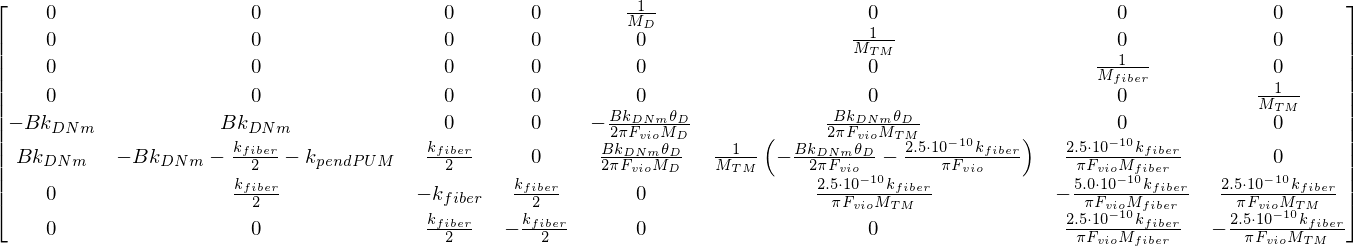

In [163]:
idx_D   = 0
idx_PUx = 1
idx_Fx  = 2
idx_TMx = 3
N_states = 4
M = [
    M_D_kg, 
    Mtm_kg, 
    M_fiber_kg, 
    Mtm_kg,
]

k = [
    bin_damp * k_D_N_m, 
    k_pendPUM_N_m, 
    k_fiber_N_m / 2, 
    k_fiber_N_m / 2,
]

theta = [
   bin_damp * k_D_N_m * loss_D / (2 * sympy.pi * F_vio_Hz),
   0,
   k_fiber_N_m / 2 * loss_fiber / (2 * sympy.pi * F_vio_Hz),
   k_fiber_N_m / 2 * loss_fiber / (2 * sympy.pi * F_vio_Hz),
]
C = [
    [1, -1,  0,  0],
    [0,  1,  0,  0],
    [0,  1, -1,  0],
    [0,  0, -1,  1],
]

mat_M = sympy.Matrix(np.diag(M))
mat_Minv = sympy.Matrix(np.diag(M))**-1
mat_0 = 0*mat_M
mat_k = sympy.Matrix(np.diag(k))
mat_theta = sympy.Matrix(np.diag(theta))
mat_C = sympy.Matrix(C)

SS_p = sympy.Matrix(np.block([
    [mat_0, mat_Minv], 
    [-mat_C.T * mat_k * mat_C, -mat_C.T * mat_theta * mat_C * mat_Minv]
]))


E = sympy.Matrix(np.block([
    [mat_C.T * mat_k * mat_C, mat_0], 
    [mat_0, mat_Minv]
]))/2

SS_p
#E

In [164]:
def subs1(expr):
    return expr.subs(subsman).subs({
            Mtm_kg: 40,
            M_fiber_kg: M_fiber_kg_true,
            F_vio_Hz: 500,
            F_pend_Hz : 1.2,
        })
SS_subst = subs1(SS_p)
E_subst = subs1(E)
#SS_subst

In [183]:

def subs2(expr):
    return expr.subs({
        loss_D: 1e-2, 
        M_D: .01,
        detune_F_D_Hz : 0,
        bin_damp : 1,
    })
SS_subst_full = subs2(SS_subst)
E_subst_full = np.matrix(subs2(E_subst).evalf().n())

model = np.array(SS_subst_full.evalf().n())
model = np.matrix([[float(x) for x in x1] for x1 in model], dtype=float)

eig, eigv = np.linalg.eig(model)

freqs = []
Qs = []
xDs = []
pDs = []
xFs = []
pFs = []
xPUs = []
pPUs = []
xTMs = []
pTMs = []
Es = []
TM_D_Ts = []
TM_D2_Ts = []
for idx in range(8):
    F = eig[idx].imag / (2 * np.pi)
    if F < 100:
        continue
    if abs(F) > .1:
        freqs.append(F)
        Q =  -1/(eig[idx].real / eig[idx].imag) / 2
        Qs.append(Q)
        xDs.append(eigv[0,idx])
        xPUs.append(eigv[1,idx])
        xFs.append(eigv[2,idx])
        xTMs.append(eigv[3,idx])
        pDs.append(eigv[N_states + 0,idx])
        pPUs.append(eigv[N_states + 1,idx])
        pFs.append(eigv[N_states + 2,idx])
        pTMs.append(eigv[N_states + 3,idx])
        E =  complex((eigv[:, idx].conjugate().T * E_subst_full * eigv[:, idx])[0,0])
        Es.append(
            E
        )
        N_thermal = (k_boltzman * 300 / E)**.5
        TM_D_Ts.append(N_thermal * eigv[3,idx])
        TM_D2_Ts.append(N_thermal * eigv[N_states + 3,idx] / 40 / eig[idx].imag)
    
import tabulate
def pclpx(lst):
    return [abs(x) if x.imag != 0 else x.real for x in lst]

data_arr =  np.array([
    pclpx(freqs), 
    pclpx(Qs), 
    pclpx(Es), 
    pclpx(TM_D_Ts), 
    pclpx(TM_D2_Ts), 
    pclpx(xDs), 
    pclpx(pDs), 
    pclpx(xFs), 
    pclpx(pFs),
    pclpx(xPUs), 
    pclpx(pPUs),
    pclpx(xTMs), 
    pclpx(pTMs),
]).T
headers = 'freqs, Qs, Es, TM_DTs, TM_DTs2, xDs, pDs, xFs, pFs, xPUs, pPUs, xTMs, pTMs'.split(',')
v = np.vstack([headers, data_arr])
print(tabulate.tabulate(v.T ))

-------  -------------  --------------
freqs    499.969         500
Qs       100.004           4.22186e+07
Es        49.9872       1092.24
TM_DTs     4.64896e-21     3.08593e-18
TM_DTs2    4.64902e-21     3.08593e-18
xDs        0.0225033       0.000158429
pDs        0.706927        0.00497719
xFs        0.000281306     0.872935
pFs        0.000128339     0.398275
xPUs       5.62584e-06     1.58519e-06
pPUs       0.706928        0.199201
xTMs       5.10721e-10     1.58468e-06
pTMs       6.41758e-05     0.199137
-------  -------------  --------------


In [184]:

def subs2(expr):
    return expr.subs({
        loss_D: 1e-2, 
        M_D: .01,
        detune_F_D_Hz : 0,
        bin_damp : 0,
    })
SS_subst_full = subs2(SS_subst)
E_subst_full = np.matrix(subs2(E_subst).evalf().n())

model = np.array(SS_subst_full.evalf().n())
model = np.matrix([[float(x) for x in x1] for x1 in model], dtype=float)

eig, eigv = np.linalg.eig(model)

freqs = []
Qs = []
xDs = []
pDs = []
xFs = []
pFs = []
xPUs = []
pPUs = []
xTMs = []
pTMs = []
Es = []
TM_D_Ts = []
TM_D2_Ts = []
for idx in range(8):
    F = eig[idx].imag / (2 * np.pi)
    if F < 100:
        continue
    if abs(F) > .1:
        freqs.append(F)
        Q =  -1/(eig[idx].real / eig[idx].imag) / 2
        Qs.append(Q)
        xDs.append(eigv[0,idx])
        xPUs.append(eigv[1,idx])
        xFs.append(eigv[2,idx])
        xTMs.append(eigv[3,idx])
        pDs.append(eigv[N_states + 0,idx])
        pPUs.append(eigv[N_states + 1,idx])
        pFs.append(eigv[N_states + 2,idx])
        pTMs.append(eigv[N_states + 3,idx])
        E =  complex((eigv[:, idx].conjugate().T * E_subst_full * eigv[:, idx])[0,0])
        Es.append(
            E
        )
        N_thermal = (k_boltzman * 300 / E)**.5
        TM_D_Ts.append(N_thermal * eigv[3,idx])
        TM_D2_Ts.append(N_thermal * eigv[N_states + 3,idx] / 40 / eig[idx].imag)
    
import tabulate
def pclpx(lst):
    return [abs(x) if x.imag != 0 else x.real for x in lst]

data_arr =  np.array([
    pclpx(freqs), 
    pclpx(Qs), 
    pclpx(Es), 
    pclpx(TM_D_Ts), 
    pclpx(TM_D2_Ts), 
    pclpx(xDs), 
    pclpx(pDs), 
    pclpx(xFs), 
    pclpx(pFs),
    pclpx(xPUs), 
    pclpx(pPUs),
    pclpx(xTMs), 
    pclpx(pTMs),
]).T
headers = 'freqs, Qs, Es, TM_DTs, TM_DTs2, xDs, pDs, xFs, pFs, xPUs, pPUs, xTMs, pTMs'.split(',')
v = np.vstack([headers, data_arr])
print(tabulate.tabulate(v.T ))

-------  --------------
freqs     500
Qs          9.99999e+08
Es       1092.29
TM_DTs      3.08593e-18
TM_DTs2     3.08593e-18
xDs         0
pDs         0
xFs         0.872957
pFs         0.398285
xPUs        1.58472e-06
pPUs        0.199143
xTMs        1.58472e-06
pTMs        0.199142
-------  --------------


In [56]:
@np.vectorize
def eigQ(p_loss_D = 1e-2, p_M_D = .01, p_detune_F_D_Hz = 0):
    SS_subst_full = SS_subst.subs({
        loss_D: p_loss_D, 
        M_D:  p_M_D,
        detune_F_D_Hz : p_detune_F_D_Hz,
        bin_damp : 1,
    })
    model = np.array(SS_subst_full.evalf().n())
    model = np.matrix([[float(x) for x in x1] for x1 in model], dtype=float)
    eig, eigv = np.linalg.eig(model)
    select = eig.imag > 0
    max_eig = np.argmax(abs(eigv[5, select]))
    eigval = eig[select][max_eig]
    Q =  -(eigval.imag / eigval.real) / 2
    return Q
    #eigvec = eigv[:, select][:, max_eig]
    #return eigval, eigvec
eigQ(1e-2, .01)

array(42218648.464087956)

array([[ 8.99999945,  8.97216901,  8.93846795, ...,  8.99862721,
         8.99890807,  8.99911126],
       [ 8.99999944,  8.9711127 ,  8.93622297, ...,  8.99849789,
         8.99880525,  8.99902769],
       [ 8.99999943,  8.97006466,  8.93400162, ...,  8.99835611,
         8.99869232,  8.99893576],
       ..., 
       [ 8.99999036,  8.94048396,  8.87361697, ...,  8.36694311,
         8.4411964 ,  8.50419661],
       [ 8.99998993,  8.94043121,  8.87351338, ...,  8.33662298,
         8.41253613,  8.4771917 ],
       [ 8.99998947,  8.94038074,  8.87341433, ...,  8.30571053,
         8.38320679,  8.44945278]])

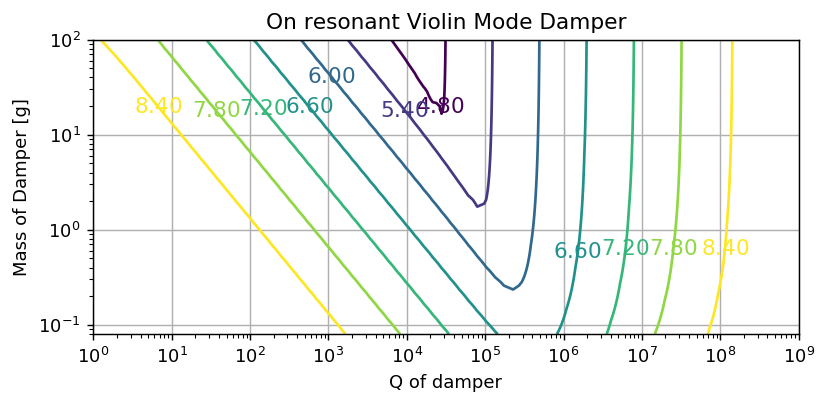

In [19]:
def contour_loss(lowest_loss = 1e-4, detune_F_D_Hz = 0):
    p_loss_D = logspaced(lowest_loss, 1, 80)
    p_M_D = logspaced(.8e-4, 1e-1, 80)
    #
    loss_D, M_D = np.meshgrid(p_loss_D, p_M_D)
    loss_arr = np.log10(eigQ(p_loss_D, M_D, detune_F_D_Hz))

    fig = pylab.figure()
    ax = fig.add_subplot(1,1,1)
    CP = ax.contour(
        1/(p_loss_D), 
        1e3 * (p_M_D), 
        loss_arr, 
        #levels = np.arange(0, 10),
    )
    labels = ax.clabel(
        CP, 
        inline = 0, 
        fontsize = 12,
        fmt = '$%1.2f$'
    )
    for l in labels:
        l.set_rotation(0)
    ax.grid(b = True)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Q of damper')
    ax.set_ylabel('Mass of Damper [g]')
    return locals()

#axB = contour_loss()
#axB['ax'].set_title('On resonant Violin Mode Damper')

axB = contour_loss(lowest_loss=1e-9)
axB['ax'].set_title('On resonant Violin Mode Damper')
axB['loss_arr']

array([[ 8.99999961,  8.99999961,  8.9999996 , ...,  8.99860723,
         8.99889315,  8.99910025],
       [ 8.9999996 ,  8.9999996 ,  8.9999996 , ...,  8.99847601,
         8.99878879,  8.99901553],
       [ 8.99999961,  8.9999996 ,  8.9999996 , ...,  8.99833223,
         8.99867471,  8.99892272],
       ..., 
       [ 8.99999963,  8.99999901,  8.9999982 , ...,  8.36210807,
         8.43693114,  8.50052667],
       [ 8.99999963,  8.99999895,  8.99999806, ...,  8.33168965,
         8.40816749,  8.4734184 ],
       [ 8.99999963,  8.99999888,  8.99999792, ...,  8.30068375,
         8.37873916,  8.44557985]])

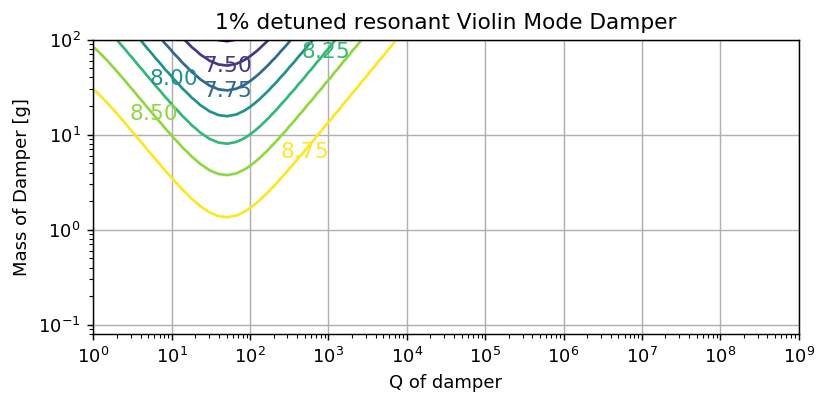

In [20]:
#axB = contour_loss(loss_eval)
#axB['ax'].set_title('1% detuned resonant Violin Mode Damper')
axB = contour_loss(lowest_loss = 1e-9, detune_F_D_Hz = .01 * 500)
axB['ax'].set_title('1% detuned resonant Violin Mode Damper')
axB['loss_arr']

array([[ 8.99999966,  8.99999955,  8.99999947, ...,  8.99862533,
         8.99890658,  8.99911038],
       [ 8.9999996 ,  8.99999954,  8.99999946, ...,  8.9984955 ,
         8.99880337,  8.99902639],
       [ 8.99999961,  8.99999953,  8.99999944, ...,  8.99835373,
         8.99869065,  8.99893436],
       ..., 
       [ 8.99999981,  8.99993817,  8.99985804, ...,  8.36642022,
         8.4407453 ,  8.50381343],
       [ 8.99999983,  8.99993239,  8.99984473, ...,  8.33608937,
         8.41207412,  8.47679769],
       [ 8.99999985,  8.99992606,  8.99983016, ...,  8.30516674,
         8.38273422,  8.44904831]])

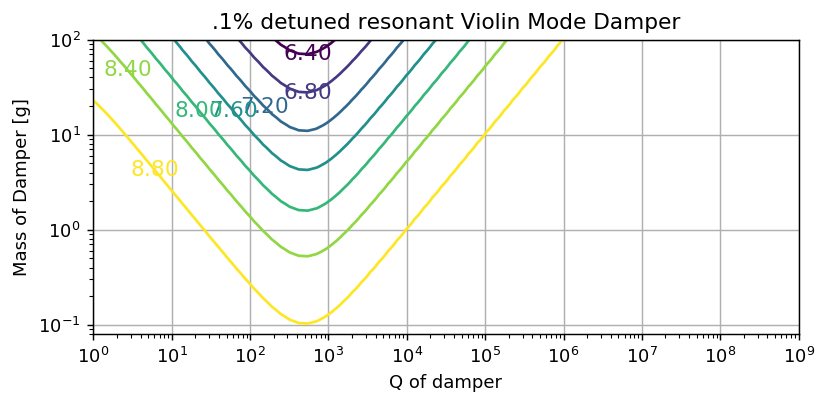

In [22]:
#axB = contour_loss(loss_eval)
#axB['ax'].set_title('1% detuned resonant Violin Mode Damper')
axB = contour_loss(lowest_loss = 1e-9, detune_F_D_Hz = .001 * 500)
axB['ax'].set_title('.1% detuned resonant Violin Mode Damper')
axB['loss_arr']

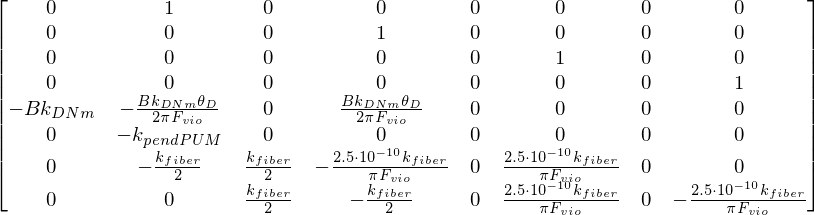

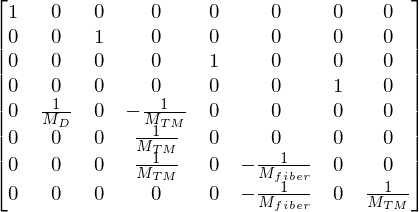

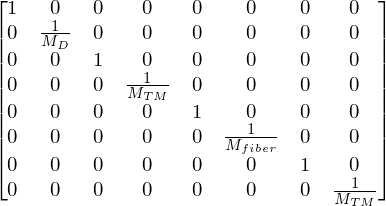

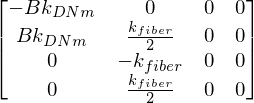

In [88]:
SS_lst  = []
SSd_lst = []
p_lst = []

p_lst.append(arr_gen(0, 1))
p_lst.append(arr_gen(1, M_D_kg))
p_lst.append(arr_gen(2, 1))
p_lst.append(arr_gen(3, Mtm_kg))
p_lst.append(arr_gen(4, 1))
p_lst.append(arr_gen(5, M_fiber_kg))
p_lst.append(arr_gen(6, 1))
p_lst.append(arr_gen(7, Mtm_kg))

#velocity terms
SS_lst.append(arr_gen(1, 1))
SSd_lst.append(arr_gen(0, 1))
SS_lst.append(arr_gen(3, 1))
SSd_lst.append(arr_gen(2, 1))
SS_lst.append(arr_gen(5, 1))
SSd_lst.append(arr_gen(4, 1))
SS_lst.append(arr_gen(7, 1))
SSd_lst.append(arr_gen(6, 1))

#spring 1-2
SS_lst.append(arr_gen(
    idx_Dx, bin_damp * -k_D_N_m, 
    idx_PUx, bin_damp * +k_D_N_m,
    idx_Dp, bin_damp * -k_D_N_m * loss_D / (2 * sympy.pi * F_vio_Hz), 
    idx_PUp, bin_damp * +k_D_N_m * loss_D / (2 * sympy.pi * F_vio_Hz),
))
SSd_lst.append(arr_gen(
    idx_Dp, 1/M_D_kg, 
    idx_PUp, - 1/Mpum_kg,
))

#spring 2-wall
SS_lst.append(arr_gen(
    idx_PUx, 1 * - k_pendPUM, 
))
SSd_lst.append(arr_gen(
    idx_PUp, 1/Mpum_kg,
))

#spring 2-3
SS_lst.append(arr_gen(
    idx_PUx, 1 * - k_fiber_N_m / 2, 
    idx_Fx,  1 * + k_fiber_N_m / 2, 
    idx_PUp, 1 * - k_fiber_N_m / 2 * loss_fiber / (2 * sympy.pi * F_vio_Hz), 
    idx_Fp,  1 * + k_fiber_N_m / 2 * loss_fiber / (2 * sympy.pi * F_vio_Hz),
))
SSd_lst.append(arr_gen(
    idx_PUp, 1/Mpum_kg, 
    idx_Fp, - 1/M_fiber_kg,
))
#spring 4-3
SS_lst.append(arr_gen(
    idx_TMx, 1 * - k_fiber_N_m / 2, 
    idx_Fx, 1 * + k_fiber_N_m / 2, 
    idx_TMp, 1 * - k_fiber_N_m / 2 * loss_fiber / (2 * sympy.pi * F_vio_Hz), 
    idx_Fp, 1 * + k_fiber_N_m / 2 * loss_fiber / (2 * sympy.pi * F_vio_Hz),
))
SSd_lst.append(arr_gen(
    idx_TMp, 1/Mtm_kg, 
    idx_Fp, - 1/M_fiber_kg,
))


SS = sympy.Matrix(SS_lst)
display(SS)
SSd = sympy.Matrix(SSd_lst)
display(SSd)
p_gen = sympy.Matrix(p_lst)
display(p_gen**-1)

SS_full = SSd.T * SS
SS_p = (p_gen * SS_full * p_gen**-1)
SS_p.simplify()
SS_p[1::2,0::2]